In [1]:
import pandas as pd
import numpy as np


class NetflixRec:
    def __init__(self, df: np.array, rz: np.array, z: list, movieTitles: list):
        self._df, self._rz, self._z, self._movieTitles = df, rz, z, movieTitles
        self.logLikeHist = []  # log likelihood history

        self.__j = self._df.shape[1]  # Number of movies
        self.__T = self._df.shape[0]  # Number people
        self.__k = len(self._z)  # num hidden variables
        # Iterators
        self.__TS = range(self.__T)  # itter over people
        self.__KS = range(self.__k)  # itter over hidden vari
        self.__JS = range(self.__j)  # itter over movies

        # Buffers
        self.rzup = self._rz.copy()  # P(R|Z) update buffer
        self.zup = [0] * self.__k  # P(Z|i)
        self.zUpdate = [0] * self.__k  # P(Z=i | R=r) for each t (person)

        # Checks
        assert self._rz.shape[0] == self.__j  # P(R|Z) should have rows = num Movies
        assert self._rz.shape[1] == self.__k  # P(R|Z) show have cols = num hidden variables

    def __prob_Rz(self, movie: str, zi: int) -> float:
        """
        P(R = r | zi )
        movie = movie name (str)
        zi = zinit index (int)
        """
        return self._rz[movie][zi]

    def __prob_R(self, ratings: list) -> float:
        """
        P(R=r)
        Probability likes the movie as a product of the movies they've seen
        ratings: viewers ratings {0,1,?} (list)
        """
        total = 0
        for i in self.__KS:
            buff = 1  # Product
            for rating, movie in zip(ratings, self.__TS):
                if rating == 0:  # Not recommended
                    buff *= (1 - self.__prob_Rz(movie, i))  # P(R=0|zi)  = 1 - P(R=1|zi)
                elif rating == 1:  # Recommended
                    buff *= self.__prob_Rz(movie, i)
                # Else pass (hasent seen) / rating = ?
            total += self._z[i] * buff
        return total

    def __eStep(self, ratings: list):
        """
        E step
        Compute P(Z|R)
        :ratings: list
        :return:  None
        """
        zUpdate = []
        for i in self.__KS:
            pzi = self._z[i]
            for rating, movieIdx in zip(ratings, self.__JS):
                if rating == 1:
                    pzi *= self._rz[movieIdx][i]
                elif rating == 0:
                    pzi *= (1 - self._rz[movieIdx][i])
            zUpdate.append(pzi)
        self.zUpdate = [buff / sum(zUpdate) for buff in zUpdate]  # list: P(Z=i| R=movie)
        self.zup = [self.zup[idx] + self.zUpdate[idx] for idx in self.__KS]

    def __mStep(self, ratings: list):
        """
        M step
        P(Rk = 1| Z=i)

        Does not include normalization b/c adds to self.rzup buffer along the way

        :param ratings: list
        :return: None
        """
        for i in self.__KS:
            for rating, movieIdx in zip(ratings, self.__JS):
                if rating == '?':
                    self.rzup[movieIdx][i] += self._rz[movieIdx][i] * self.zUpdate[i]
                elif rating == 1:
                    self.rzup[movieIdx][i] += self.zUpdate[i]

    def getMovieTitles(self) -> list:
        return self._movieTitles

    def getRZ(self) -> np.array:
        """
        P(R=1 | Z =i)
        :return:
        """
        return self._rz

    def getZ(self) -> np.array:
        """
        P(Z=i)
        :return:
        """
        return self._z

    def getLogHist(self) -> list:
        return self.logLikeHist

    def plotLogLikeHist(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15, 15))
        plt.plot(self.logLikeHist)
        plt.xlabel("Iteration")
        plt.ylabel("Log Likelihood")
        plt.title("Log Likelihood vs  Itteration")
        plt.show()

    def meanPopularity(self) -> pd.DataFrame:
        """
        Displays mean popularity  of movies (sorted)
        :return:
        """

        moviePop = {}
        for mov in self.__JS:
            buff = self._df[:, mov]
            buff = [rating for rating in buff if rating != "?"]
            mean_rating = sum(buff) / len(buff)
            movie = self._movieTitles[mov]
            moviePop[movie] = mean_rating
            # moviePop[mean_rating] = "\033[1m%s:\033[0m average rating of %0.4f" % (
            # movie, mean_rating)

        meanRating = pd.DataFrame.from_dict(data=moviePop, orient="index", columns=["rating"])
        meanRating.sort_values("rating", ascending=True, inplace=True)
        # Print ratings
        for movie in meanRating.index:
            rating = meanRating.loc[movie, "rating"]
            print("\033[1m%s:\033[0m average rating of %0.4f" % (movie, rating))
        return meanRating

    def computeAndUpdate(self, itter: int = 128):
        """
        Computes log likelihood and updates P(z=i) and P(R=1|z=i)
        :param itter: num itterations
        :return: None
        """
        for _ in range(itter + 1):
            # Update buffers
            self.rzup[:][:] = 0  # Set buffer to 0 for summations
            self.zup = [0] * self.__k  # P(Z=i) buffer
            logLike = 0
            for t in self.__TS:  # Iterate over people
                ratings = self._df[t]  # get ratings of people
                logLike += np.log(self.__prob_R(ratings))
                self.__eStep(ratings)
                self.__mStep(ratings)

            # Normalization of M step
            for i in self.__KS:
                self.rzup[:, i] = self.rzup[:, i] / self.zup[i]
                self.zup[i] = self.zup[i] / self.__T

            # Update
            self._rz = self.rzup.copy()
            self._z = self.zup.copy()

            self.logLikeHist.append(logLike / self.__T)

    def makeRecomendations(self, resp: list) -> pd.DataFrame:
        """
        resp should be list with 1 = like, 0 = dislike, ? = Hasnt watched

        Gives user suggestions based on prior responses

        :param resp: user ratings of movies seen + if not seen
        :return: pd.DataFrame
        """
        # Checking to make sure ratings is the correct length
        assert len(resp) == self.__j

        # Computing coefficients
        pzr = []
        for i in self.__KS:
            pzi = self._z[i]
            for rating, movieIdx in zip(resp, self.__JS):
                if rating == 1:
                    pzi *= self.__prob_Rz(movieIdx, i)
                elif rating == 0:
                    pzi *= (1 - self.__prob_Rz(movieIdx, i))
            pzr.append(pzi)
        pzr = [pzi / sum(pzr) for pzi in pzr]

        # rating suggestions
        results = {}
        for rating, movieIdx in zip(resp, self.__JS):
            title = self._movieTitles[movieIdx]
            buff = 0
            if rating == "?":
                for i in self.__KS:
                    buff += pzr[i] * self.__prob_Rz(movieIdx, i)
                results[title] = buff

        suggestions = pd.DataFrame.from_dict(data=results, orient="index", columns=["rating"])
        suggestions.sort_values("rating", ascending=False, inplace=True)
        return suggestions

In [2]:
 # Sample data
titles = open("hw8_movies.txt").read().split("\n")
ids = open("hw8_ids.txt").read().split("\n")
df = pd.read_csv("hw8_ratings.txt", sep=" ", names=titles)
df["ids"] = ids
df.set_index("ids", inplace=True)
df = df.applymap(lambda x: int(x) if x != "?" else x)
dfOrig = df.copy()

# probs
z = [float(val) for val in open("hw8_probZ_init.txt").read().strip().split('\n')]
rz = pd.read_csv("hw8_probRgivenZ_init.txt", sep=" ", header=None).astype(float)
rz = rz.replace("", None)
rz.dropna(axis=1, inplace=True)
rz.columns = range(len(rz.columns))
df, rz, z = df.to_numpy(), rz.to_numpy(), z

rec = NetflixRec(df, rz, z, titles)


# Part A 
Sanity Check

In [3]:
sanityCheck = rec.meanPopularity()

Fifty_Shades_of_Grey: average rating of 0.3483
The_Last_Airbender: average rating of 0.3676
World_War_Z: average rating of 0.5200
Magic_Mike: average rating of 0.5455
Chappaquidick: average rating of 0.5455
Terminator:_Dark_Fate: average rating of 0.5625
I_Feel_Pretty: average rating of 0.5789
Man_of_Steel: average rating of 0.5843
Hustlers: average rating of 0.5926
Fast_&_Furious:_Hobbs_&_Shaw: average rating of 0.6203
Prometheus: average rating of 0.6269
Us: average rating of 0.6275
Star_Wars:_The_Force_Awakens: average rating of 0.6348
The_Shape_of_Water: average rating of 0.6515
Pokemon_Detective_Pikachu: average rating of 0.6559
The_Hunger_Games: average rating of 0.6607
Thor: average rating of 0.6618
Fast_Five: average rating of 0.6735
Once_Upon_a_Time_in_Hollywood: average rating of 0.6849
Good_Boys: average rating of 0.6923
The_Perks_of_Being_a_Wallflower: average rating of 0.6957
Rocketman: average rating of 0.7059
Jurassic_World: average rating of 0.7234
Bridemaids: average r

# Part E
implmentation

In [4]:
rec.computeAndUpdate(itter=128)

In [5]:
loghist = rec.getLogHist()
keeps = [0,1,2,4,8,16,32,64,128]
logLikeHist = [loghist[i] for i in keeps]
pd.DataFrame(data={"logLike": logLikeHist}, index= keeps)

,logLike
0,-30.686345
1,-18.646477
2,-16.642724
4,-15.355375
8,-14.652171
16,-14.464613
32,-14.413632
64,-14.363246
128,-14.351253


In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/rose/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

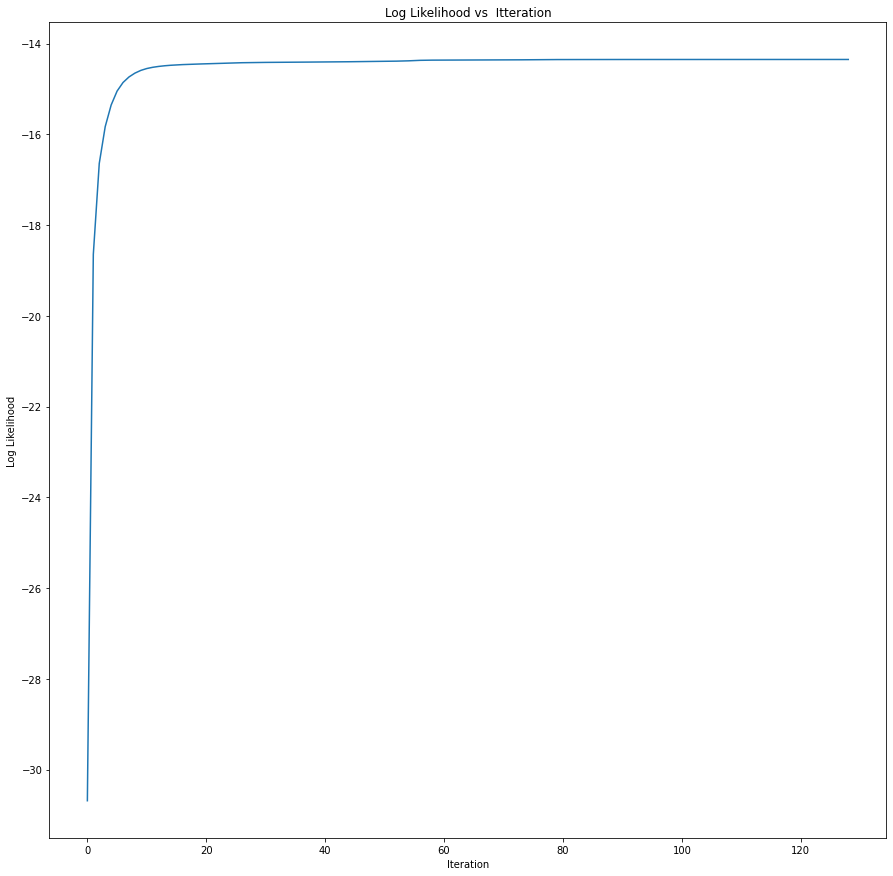

In [6]:
rec.plotLogLikeHist()

# Part f
Recommondations

In [7]:
myRatings = dfOrig.loc["A13955782", :].values
recommondation = rec.makeRecomendations(myRatings)
print(recommondation.to_string())

                                                rating
The_Avengers                                  0.994294
Good_Boys                                     0.966131
The_Social_Network                            0.965858
Her                                           0.964319
Ready_Player_One                              0.958036
Harry_Potter_and_the_Deathly_Hallows:_Part_2  0.952389
Avengers:_Infinity_War                        0.952273
Bridemaids                                    0.947950
Avengers:_Age_of_Ultron                       0.944145
Spiderman:_Far_From_Home                      0.941236
Avengers:_Endgame                             0.937149
The_Theory_of_Everything                      0.925108
Harry_Potter_and_the_Deathly_Hallows:_Part_1  0.923404
Fast_Five                                     0.921846
The_Hateful_Eight                             0.919741
Three_Billboards_Outside_Ebbing               0.919601
Hidden_Figures                                0.917145
Parasite  